## Imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


## Functions

In [39]:
def backtest(stock1, initial_capital=100000):
    stock1['Returns'] = stock1['close'].pct_change()

    stock1['Strategy_Returns'] = stock1['Returns'] * stock1['Position'].shift(1)

    stock1['Cumulative_Strategy_Returns'] = (1 + stock1['Strategy_Returns']).cumprod()

    stock1['Portfolio_Value'] = initial_capital * stock1['Cumulative_Strategy_Returns']

    stock1['Profit/Loss'] = stock1['Portfolio_Value'] - initial_capital

    return stock1


## Data Loading and Preprocessing

In [40]:
stock1 = pd.read_csv('data/EGX_DLY_COMI, 1D.csv')
stock2 = pd.read_csv('data/EGX_DLY_EGX30, 1D.csv')
stock3 = pd.read_csv('data/EGX_DLY_EMFD, 1D.csv')
stock4 = pd.read_csv('data/EGX_DLY_ISPH, 1D.csv')


# close_prices = pd.DataFrame({
#     'Stock1': stock1['Close'],
#     'Stock2': stock2['Close'],
#     'Stock3': stock3['Close'],
#     'Stock4': stock4['Close']
# })


Change the datatype of time

In [41]:
stock1['time'] = pd.to_datetime(stock1['time'], unit='s')

stock1.set_index('time', inplace=True)

print(stock1.head())


                         open      high       low     close
time                                                       
2001-05-15 07:00:00  0.839019  0.839019  0.827202  0.831220
2001-05-16 07:00:00  0.827202  0.836419  0.823184  0.826020
2001-05-17 07:00:00  0.827202  0.827202  0.820111  0.824366
2001-05-20 07:00:00  0.815621  0.821293  0.815385  0.816566
2001-05-21 07:00:00  0.813257  0.850836  0.809476  0.831456


Add More Features

In [42]:
stock1['Short_MA'] = stock1['close'].rolling(window=40, min_periods=1).mean()
stock1['Long_MA'] = stock1['close'].rolling(window=100, min_periods=1).mean()

stock1.head()

,open,high,low,close,Short_MA,Long_MA
time,,,,,,
2001-05-15 07:00:00,0.839019,0.839019,0.827202,0.831220,0.831220,0.831220
2001-05-16 07:00:00,0.827202,0.836419,0.823184,0.826020,0.828620,0.828620
2001-05-17 07:00:00,0.827202,0.827202,0.820111,0.824366,0.827202,0.827202
2001-05-20 07:00:00,0.815621,0.821293,0.815385,0.816566,0.824543,0.824543
2001-05-21 07:00:00,0.813257,0.850836,0.809476,0.831456,0.825925,0.825925


In [ ]:
stock1.dropna(inplace=True)


## Data Visualization

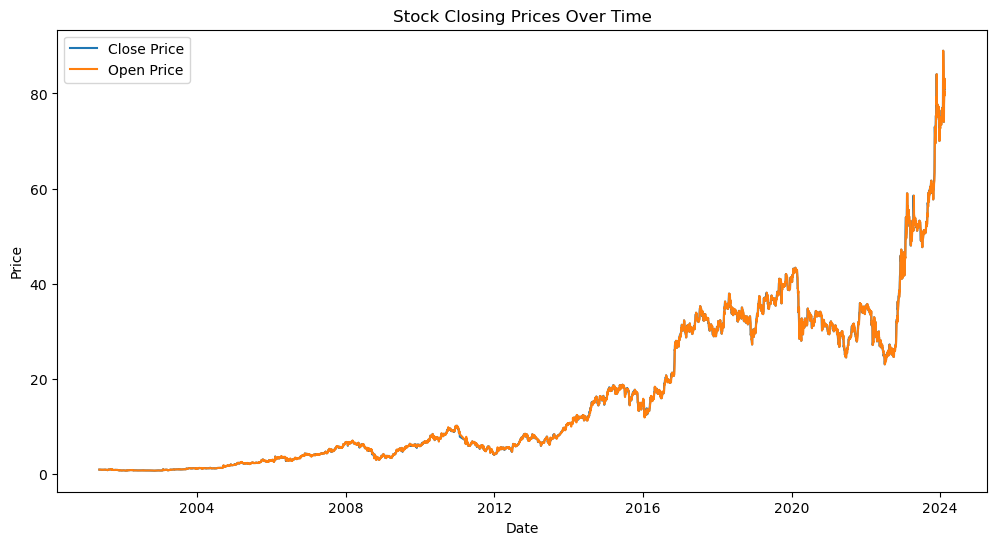

In [43]:

plt.figure(figsize=(12, 6))
plt.plot(stock1['close'], label='Close Price')
plt.plot(stock1['open'], label='Open Price')

plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


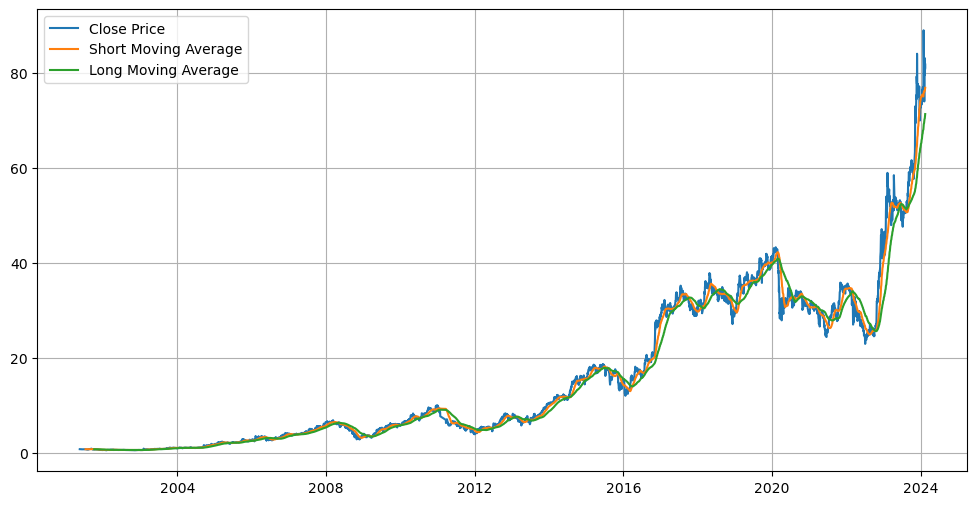

In [44]:
stock1['Short_MA'] = stock1['close'].rolling(window=40).mean()
stock1['Long_MA'] = stock1['close'].rolling(window=100).mean()


plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(stock1['close'],label='Close Price')
plt.plot(stock1['Short_MA'], label='Short Moving Average')
plt.plot(stock1['Long_MA'], label='Long Moving Average')
plt.legend(loc=2)
plt.show()

In [45]:
stock1['Signal'] = 0
stock1['Signal'] = np.where(stock1['Short_MA'] > stock1['Long_MA'], 1, 0)
stock1['Position'] = stock1['Signal'].diff()

print(stock1.head(100))


                         open      high       low     close  Short_MA  \
time                                                                    
2001-05-15 07:00:00  0.839019  0.839019  0.827202  0.831220       NaN   
2001-05-16 07:00:00  0.827202  0.836419  0.823184  0.826020       NaN   
2001-05-17 07:00:00  0.827202  0.827202  0.820111  0.824366       NaN   
2001-05-20 07:00:00  0.815621  0.821293  0.815385  0.816566       NaN   
2001-05-21 07:00:00  0.813257  0.850836  0.809476  0.831456       NaN   
...                       ...       ...       ...       ...       ...   
2001-09-30 08:00:00  0.779933  0.791750  0.779697  0.783478  0.844295   
2001-10-01 08:00:00  0.791278  0.791278  0.762680  0.772843  0.844727   
2001-10-02 08:00:00  0.769298  0.772843  0.753463  0.757244  0.844543   
2001-10-03 08:00:00  0.756299  0.768116  0.749208  0.754644  0.843592   
2001-10-04 08:00:00  0.756535  0.756535  0.746845  0.752754  0.841755   

                      Long_MA  Signal  Position  


## Possible Models 

In [46]:
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps), :-1].values)
        y.append(data.iloc[i + time_steps, -1])
    return np.array(X), np.array(y)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split the data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences
time_steps = 10
X_train, y_train = create_sequences(pd.DataFrame(train_data), time_steps)
X_test, y_test = create_sequences(pd.DataFrame(test_data), time_steps)

# Build and train the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], scaled_data.shape[1]-1)), predictions), axis=1))[:, -1]
actual = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], scaled_data.shape[1]-1)), y_test.reshape(-1, 1)), axis=1))[:, -1]

# Generate signals
signals = np.where(predictions > np.roll(predictions, 1), 1, -1)


,open,high,low,close,Short_MA,Long_MA,Signal,Position
time,,,,,,,,
2001-05-15 07:00:00,0.839019,0.839019,0.827202,0.831220,NaN,NaN,0,NaN
2001-05-16 07:00:00,0.827202,0.836419,0.823184,0.826020,NaN,NaN,0,0.0
2001-05-17 07:00:00,0.827202,0.827202,0.820111,0.824366,NaN,NaN,0,0.0
2001-05-20 07:00:00,0.815621,0.821293,0.815385,0.816566,NaN,NaN,0,0.0
2001-05-21 07:00:00,0.813257,0.850836,0.809476,0.831456,NaN,NaN,0,0.0
